In [1]:
%reload_ext autoreload
%autoreload 2
#Custom Files
from DataManager import dataManager
from DataManagerUtil import *
import GCN as GCN
import GCNutil as GCNutil
import GDE as GDE
import GDEutil as GDEutil
import GDEsolvers as GDEsolvers
import MLP as MLP
from Full_model import Integrated_Model

#Standard Libraries
# Torch
import torch
import torch.autograd
import torch.nn as nn
import torch.nn.functional as F
#Numpy
import numpy as np

name: X_test
shape: (640, 35, 2649)
-----------------------
name: X_train
shape: (640, 35, 2564)
-----------------------
name: clip_sizes_test
shape: (2, 102)
-----------------------
name: clip_sizes_train
shape: (2, 101)
-----------------------
name: conv_sizes
shape: (1, 1)
-----------------------
name: n_pre_szr
shape: (1, 1)
-----------------------
name: sel_win_nums_test
shape: (1, 2649)
-----------------------
name: sel_win_nums_train
shape: (1, 2564)
-----------------------
name: soz_ch_ids
shape: (7, 1)
-----------------------
name: stride_sec
shape: (1, 1)
-----------------------
name: window_size_sec
shape: (1, 1)
-----------------------
name: y_test
shape: (1, 2649)
-----------------------
name: y_train
shape: (1, 2564)
-----------------------
print sample EGG signal from one node:


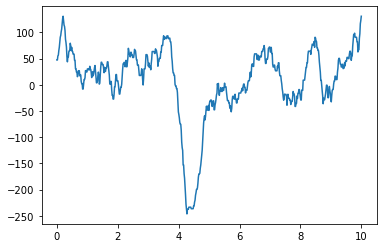

In [2]:
#Loading everything from the dataset
filepath = 'datasets\pat_FR_273.mat' #264 253 620 273
variables = load_patient_data(filepath, verbose = True)

In [3]:
dm = dataManager(variables["X_train"],variables["X_test"],variables["y_train"],variables["y_test"],10**(-4))

--------data manager successfully initialized--------


In [4]:
#reduce redundant nodes
#from DataManager import get_label_variance as glv
#print(glv(dm.X_train, dm.Y_train))
#print(np.argsort(glv(dm.X_train, dm.Y_train)))
print(dm)
dm.apply_dvariance_filter(28)
dm.mean_pooling_1d(size = 24, stride = 20, padding = 0)
print(dm)

X_train: shape of(2562, 35, 640)
X_test: shape of(2649, 35, 640)
Y_train: shape of(2562, 1)
Y_test: shape of(2649, 1)
A_train: shape of(35, 35)
A_test: shape of(35, 35)
P_avg_train: shape of(35, 35)
P_avg_test: shape of(35, 35)
--------data successfully filtered (dvariance)--------
X_train: shape of(2562, 28, 31)
X_test: shape of(2649, 28, 31)
Y_train: shape of(2562, 1)
Y_test: shape of(2649, 1)
A_train: shape of(28, 28)
A_test: shape of(28, 28)
P_avg_train: shape of(28, 28)
P_avg_test: shape of(28, 28)


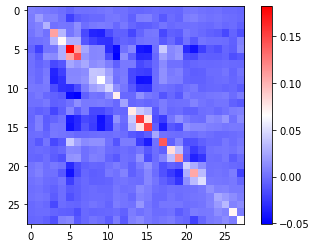

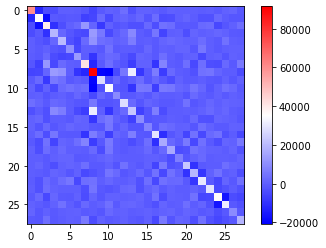

In [5]:
show_heat_map(dm.P_avg_train)
show_heat_map(dm.conv_avg_train)

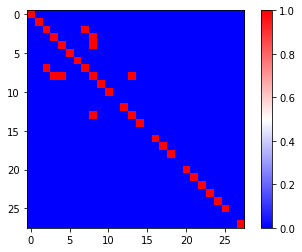

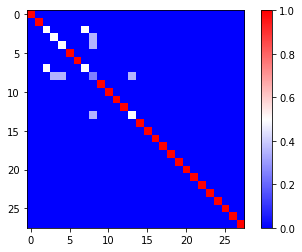

In [6]:
# adjacency generated by convariance
A2 = (dm.conv_avg_train > 10000)# + (dm.conv_avg_train < -8000) 
show_heat_map(A2)
show_heat_map(create_DAD(A2))

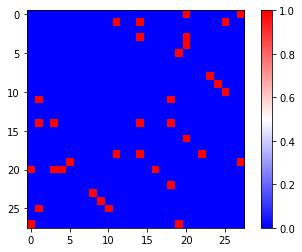

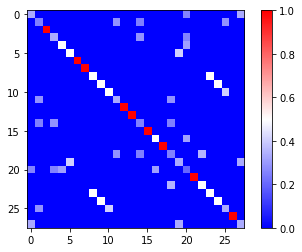

In [7]:
#randomly generated A
b = np.random.randint(-2000,2000,size=dm.conv_avg_train.shape)
A3 = (b + b.T)/2 > 1500
show_heat_map(A3)
show_heat_map(create_DAD(A3))

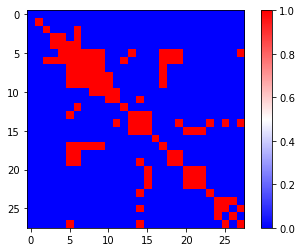

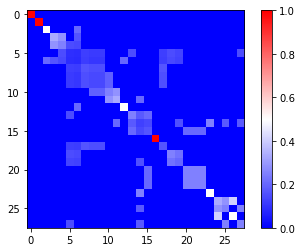

In [8]:
n = 10.5*10**-3
dm.re_threshold(n)
show_heat_map(dm.A_train)
show_heat_map(create_DAD(dm.A_train))
#print(create_DAD(dm.A_train))
Araw =  A3#dm.A_train

In [17]:
GCNparameters = {
    'body': dm.X_train.shape[2],
    'M': dm.X_train.shape[0],
    'batch_size': 256,
    'n_layers': 1,
    'num_epochs': 1,
    'learning_rate': 1e-3,
    'weight_decay': 5e-3
}
GDEparameters = {
    'body': dm.X_train.shape[2],
    'solver': GDEsolvers.explicit_RK,
    'solver_params': {
    "t0": 0,
    "t1": 0.25,
    "N": 5,
    "b_tableau": GDEsolvers.RK4
     },
    'hidden_layers': 1,
    'M': dm.X_train.shape[0],
    'batch_size': 128,
    'num_epochs': 1,
    'learning_rate': 1e-3,
    'weight_decay': 5e-3
}
MLPparametersGCN = {
    'n_layers':2,
    'layer_size_factor':[1,50], 
    'dropout':[0.3, 0.15],
    'batch_size': 128,
    'num_epochs': 900,
    'learning_rate': 6e-4,
    'weight_decay': 5e-3,
    'betas': (0.9, 0.999), 
    'eps': 1e-08
}
MLPparametersGDE = {
    'n_layers':2,
    'layer_size_factor':[1, 50], 
    'dropout':[0.3, 0.15],
    'batch_size': 128,
    'num_epochs': 900,
    'learning_rate': 6e-4,
    'weight_decay': 5e-3,
    'betas': (0.9, 0.999), 
    'eps': 1e-08
}
#print(GCNparameters['M'])

  0%|          | 0/21 [00:00<?, ?it/s]

----------Training GCN-----------
device set to cpu
Epoch: 1   Batch: 11 of size 256   Train loss: 194.2757568359375   Valid loss: 192.14297485351562
----------Training Ends-----------
----------Training GDE-----------
device set to cpu


 10%|▉         | 2/21 [00:00<00:02,  7.73it/s]

 19%|█▉        | 4/21 [00:00<00:02,  7.74it/s]

 29%|██▊       | 6/21 [00:00<00:02,  7.49it/s]

 38%|███▊      | 8/21 [00:01<00:01,  7.45it/s]

 48%|████▊     | 10/21 [00:01<00:01,  7.62it/s]

 57%|█████▋    | 12/21 [00:01<00:01,  7.66it/s]

 67%|██████▋   | 14/21 [00:01<00:00,  7.59it/s]

 76%|███████▌  | 16/21 [00:02<00:00,  7.54it/s]

 86%|████████▌ | 18/21 [00:02<00:00,  7.60it/s]

100%|██████████| 21/21 [00:02<00:00,  7.87it/s]

Epoch: 1   Batch: 21 of size 128   Train loss: 180.85382080078125   Valid loss: 180.93605041503906
----------Training Ends-----------


Average Ictal and Non-Ictal Simularity Matrix for GCN
Average ictal


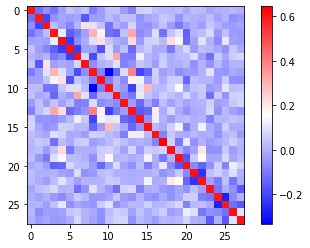

Average Non-Ictal


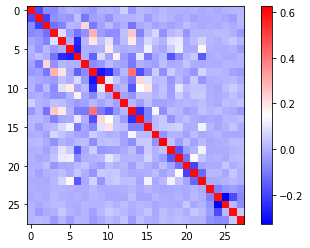

Average Ictal and Non-Ictal Simularity Matrix for GDE
Average ictal


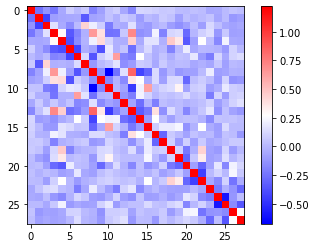

Average Non-Ictal


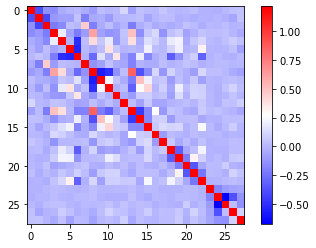

Sample Ictal and Non-Ictal Simularity Matrix for GCN
sample ictal


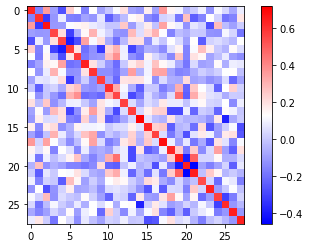

sample Non-Ictal


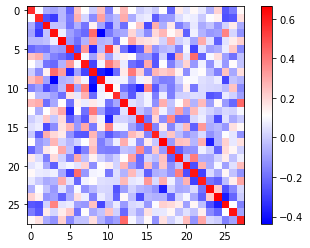

Sample Ictal and Non-Ictal Simularity Matrix for GDE
sample ictal


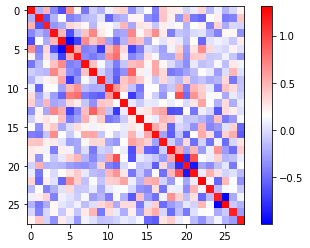

sample Non-Ictal


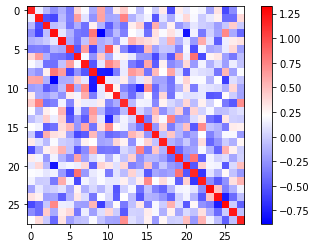

----------Training MLP-----------
0.512 ----------saved-----------
0.581 ----------saved-----------
0.628 ----------saved-----------
0.653 ----------saved-----------
0.669 ----------saved-----------
0.692 ----------saved-----------
0.707 ----------saved-----------
0.719 ----------saved-----------
0.735 ----------saved-----------
0.748 ----------saved-----------
0.767 ----------saved-----------
0.779 ----------saved-----------
0.792 ----------saved-----------
0.801 ----------saved-----------
0.807 ----------saved-----------
0.809 ----------saved-----------
0.812 ----------saved-----------
0.815 ----------saved-----------
0.819 ----------saved-----------
0.822 ----------saved-----------
0.825 ----------saved-----------
0.826 ----------saved-----------
0.828 ----------saved-----------
0.831 ----------saved-----------
0.834 ----------saved-----------
0.834 ----------saved-----------
0.836 ----------saved-----------
0.838 ----------saved-----------
0.841 ----------saved-----------
0.842 ---

In [18]:
IM = Integrated_Model(GCNparameters, GDEparameters, MLPparametersGCN, MLPparametersGDE, dm, create_DAD(A3))

GCN accuracy:
device set to cuda
threshold: 0.05  validation loss: 0.1923 F1 accuracy 0.508 Precision accuracy 0.368 Recall accuracy 0.82 AUC accuracy: 0.906
device set to cuda
threshold: 0.1  validation loss: 0.1923 F1 accuracy 0.587 Precision accuracy 0.494 Recall accuracy 0.722 AUC accuracy: 0.906
device set to cuda
threshold: 0.15  validation loss: 0.1923 F1 accuracy 0.635 Precision accuracy 0.599 Recall accuracy 0.675 AUC accuracy: 0.906
device set to cuda
threshold: 0.2  validation loss: 0.1923 F1 accuracy 0.655 Precision accuracy 0.689 Recall accuracy 0.624 AUC accuracy: 0.906
device set to cuda
threshold: 0.25  validation loss: 0.1923 F1 accuracy 0.668 Precision accuracy 0.764 Recall accuracy 0.593 AUC accuracy: 0.906
device set to cuda
threshold: 0.3  validation loss: 0.1923 F1 accuracy 0.677 Precision accuracy 0.828 Recall accuracy 0.573 AUC accuracy: 0.906
device set to cuda
threshold: 0.35  validation loss: 0.1923 F1 accuracy 0.683 Precision accuracy 0.878 Recall accuracy 0

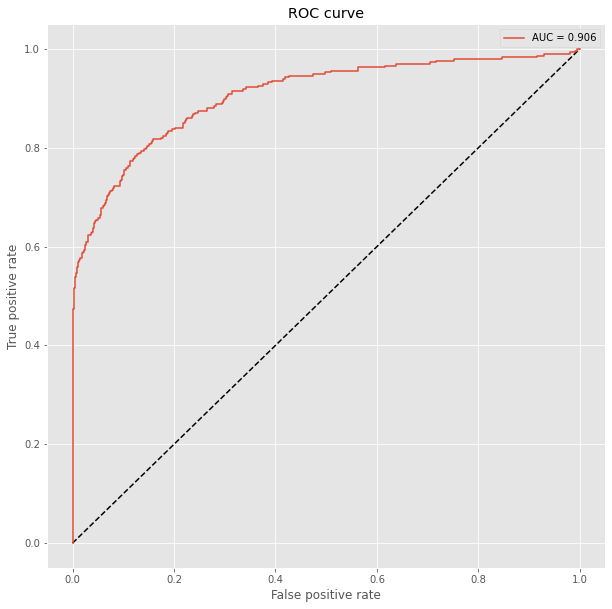

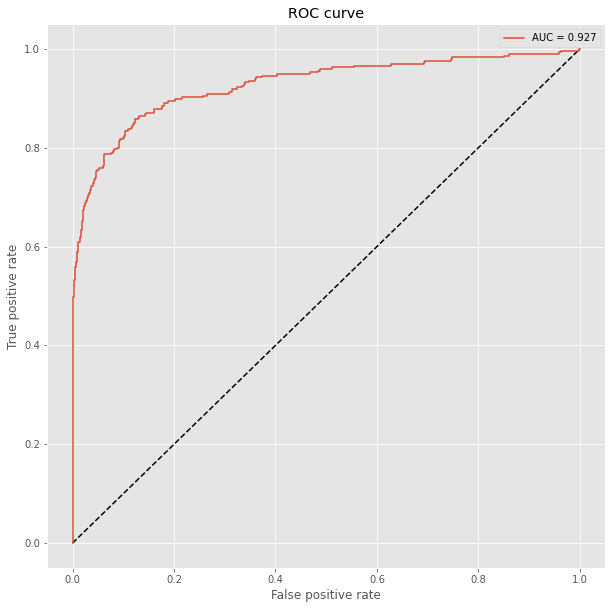

In [19]:
IM.print_accuracy(dm, Araw, device_name = 'cpu')